In [79]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import umap
from sklearn.manifold import TSNE

In [80]:
# Define paths
base_path = '/content/' # Updated base_path to /content/
data_path = '/content/' # Updated data_path to /content/

# Load your files
# Removed: dataset = pd.read_csv(data_path + 'dataset.csv') as it caused FileNotFoundError
preprocessed_data = np.load(data_path + 'Copy of processed_ids.npy') # Updated filename
spectrogram_data = np.load(data_path + 'Copy of processed_spectrograms.npy') # Updated filename

# Check shapes
# Removed: print(f"Dataset shape: {dataset.shape}")
print(f"Preprocessed data shape: {preprocessed_data.shape}")
print(f"Spectrogram shape: {spectrogram_data.shape}")
# Removed DEBUG block as X is defined in a later cell.

# Check original data too
print("\nORIGINAL DATA:")
print(f"preprocessed_data shape: {preprocessed_data.shape}")
print(f"spectrogram_data shape: {spectrogram_data.shape}")
print("="*60)

Preprocessed data shape: (683,)
Spectrogram shape: (683, 128, 256)

ORIGINAL DATA:
preprocessed_data shape: (683,)
spectrogram_data shape: (683, 128, 256)


In [81]:
# ========================================
# CELL 3 (COMPLETE FIX): Fix Data Loading
# ========================================
print("="*60)
print("FIXING DATA PREPROCESSING")
print("="*60)

# Load raw data again
preprocessed_data = np.load(data_path + 'Copy of processed_ids.npy')
spectrogram_data = np.load(data_path + 'Copy of processed_spectrograms.npy')

print(f"Raw preprocessed_data shape: {preprocessed_data.shape}")
print(f"Raw spectrogram_data shape: {spectrogram_data.shape}")

# The issue: your data was incorrectly reshaped to (683, 1)
# Let's use the original data properly

# Option 1: Use preprocessed_data if it has features
if len(preprocessed_data.shape) == 2 and preprocessed_data.shape[1] > 1:
    X_raw = preprocessed_data
    print(f"\n✓ Using preprocessed_data: {X_raw.shape}")

elif len(preprocessed_data.shape) == 2 and preprocessed_data.shape[0] > 1 and preprocessed_data.shape[1] == 1:
    # Data is (n, 1) - this is wrong! Need to use spectrogram instead
    print("\n⚠️ Preprocessed data has only 1 feature. Using spectrogram instead...")

    if len(spectrogram_data.shape) == 3:
        # Spectrogram is (n_samples, time, frequency)
        n_samples = spectrogram_data.shape[0]
        X_raw = spectrogram_data.reshape(n_samples, -1)
        print(f"✓ Flattened spectrogram to: {X_raw.shape}")
    elif len(spectrogram_data.shape) == 2:
        X_raw = spectrogram_data
        print(f"✓ Using 2D spectrogram: {X_raw.shape}")
    else:
        raise ValueError("Cannot process spectrogram data!")

elif len(preprocessed_data.shape) == 1:
    # 1D array - need to reshape based on number of samples
    print("\n⚠️ Preprocessed data is 1D. Reshaping based on spectrogram...")

    if len(spectrogram_data.shape) >= 2:
        n_samples = spectrogram_data.shape[0]
        n_features = len(preprocessed_data) // n_samples

        if n_features > 1:
            X_raw = preprocessed_data.reshape(n_samples, n_features)
            print(f"✓ Reshaped to: {X_raw.shape}")
        else:
            # Fall back to spectrogram
            X_raw = spectrogram_data.reshape(n_samples, -1)
            print(f"✓ Using flattened spectrogram: {X_raw.shape}")
    else:
        raise ValueError("Cannot determine data shape!")
else:
    # Last resort: use spectrogram
    print("\n⚠️ Using spectrogram data...")
    X_raw = spectrogram_data.reshape(spectrogram_data.shape[0], -1)
    print(f"✓ Shape: {X_raw.shape}")

# Verify we have good data
n_samples, n_features = X_raw.shape
print(f"\n{'='*60}")
print(f"FINAL DATA CHECK")
print(f"{'='*60}")
print(f"✓ Samples: {n_samples}")
print(f"✓ Features: {n_features}")

if n_features < 2:
    raise ValueError(f"ERROR: Only {n_features} feature(s)! Need at least 10 features for meaningful analysis.")

if n_samples < 10:
    raise ValueError(f"ERROR: Only {n_samples} sample(s)! Need at least 10 samples.")

# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

print(f"\n✓ Normalization complete")
print(f"✓ Final shape: {X.shape}")
print(f"✓ Feature range: [{X.min():.3f}, {X.max():.3f}]")
print(f"✓ Mean: {X.mean():.6f}, Std: {X.std():.3f}")

FIXING DATA PREPROCESSING
Raw preprocessed_data shape: (683,)
Raw spectrogram_data shape: (683, 128, 256)

⚠️ Preprocessed data is 1D. Reshaping based on spectrogram...
✓ Using flattened spectrogram: (683, 32768)

FINAL DATA CHECK
✓ Samples: 683
✓ Features: 32768

✓ Normalization complete
✓ Final shape: (683, 32768)
✓ Feature range: [-6.143, 4.342]
✓ Mean: 0.000000, Std: 1.000


In [82]:
# ========================================
# CELL 4: Build VAE with Correct Loss Function
# ========================================
import gc
gc.collect()
tf.keras.backend.clear_session()

latent_dim = 32
input_dim = X.shape[1]  # 32768

print("="*60)
print("BUILDING VAE MODEL")
print("="*60)
print(f"Input dimension: {input_dim}")
print(f"Latent dimension: {latent_dim}")

# Encoder
encoder_inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(512, activation='relu')(encoder_inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sampling
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
decoder_outputs = layers.Dense(input_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

# VAE Model with FIXED loss function
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=0.1, **kwargs): # Added beta
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta # KL weight
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Use REDUCE_SUM to capture the magnitude of 32k features
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=-1)
            )

            # Apply Beta to prevent the KL loss from collapsing the clusters
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
            )

            total_loss = reconstruction_loss + (self.beta * kl_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction))

        # KL loss
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )

        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "recon_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-4))

print("\n✓ VAE model built successfully!")


BUILDING VAE MODEL
Input dimension: 32768
Latent dimension: 32

✓ VAE model built successfully!



TRAINING VAE
Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - kl_loss: 467852576.0000 - loss: 46822256.0000 - recon_loss: 37001.3438 - val_kl_loss: 0.6048 - val_loss: 0.9891 - val_recon_loss: 0.3844
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - kl_loss: 2166343.0000 - loss: 246620.4531 - recon_loss: 29986.1719 - val_kl_loss: 0.4603 - val_loss: 0.8450 - val_recon_loss: 0.3847
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - kl_loss: 823187.5000 - loss: 112199.7969 - recon_loss: 29881.0625 - val_kl_loss: 0.6038 - val_loss: 0.9922 - val_recon_loss: 0.3883
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - kl_loss: 14827.7217 - loss: 28929.1465 - recon_loss: 27446.3789 - val_kl_loss: 2.0916 - val_loss: 2.4906 - val_recon_loss: 0.3990
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - kl_loss: 2129.6191 - loss: 28735.0469 - recon_loss: 28522.0840 - val_kl_loss: 1.6058 - val_loss: 2.0103 - val_recon_loss: 0.4045
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - kl_los

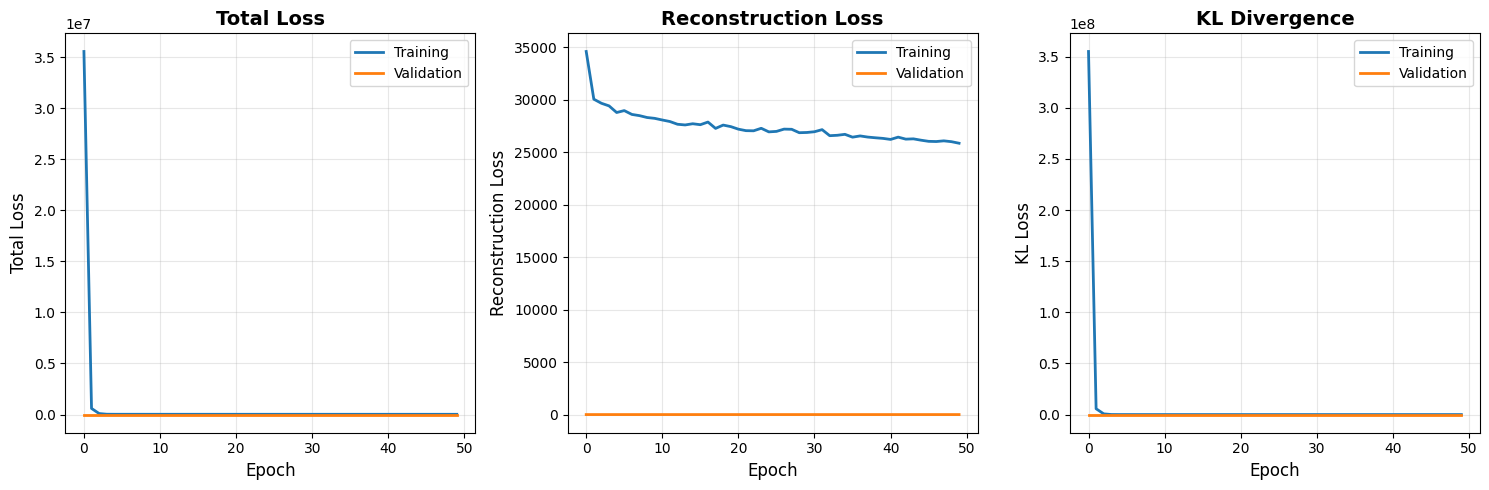


✓ Training complete!


In [83]:
# ========================================
# CELL 5: Train VAE
# ========================================
print("\n" + "="*60)
print("TRAINING VAE")
print("="*60)

history = vae.fit(
    X,
    epochs=50,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Total Loss', fontsize=12)
plt.legend()
plt.title('Total Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['recon_loss'], label='Training', linewidth=2)
plt.plot(history.history['val_recon_loss'], label='Validation', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Reconstruction Loss', fontsize=12)
plt.legend()
plt.title('Reconstruction Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history.history['kl_loss'], label='Training', linewidth=2)
plt.plot(history.history['val_kl_loss'], label='Validation', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('KL Loss', fontsize=12)
plt.legend()
plt.title('KL Divergence', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_path + 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training complete!")

In [84]:
# ========================================
# CELL 6: Extract Latent Features
# ========================================
print("\n" + "="*60)
print("EXTRACTING LATENT FEATURES")
print("="*60)

z_mean, _, _ = encoder.predict(X, verbose=0)
print(f"✓ Latent features shape: {z_mean.shape}")



EXTRACTING LATENT FEATURES
✓ Latent features shape: (683, 32)


In [85]:
# ========================================
# CELL 7: VAE + K-Means Clustering
# ========================================
print("\n" + "="*60)
print("VAE + K-MEANS CLUSTERING")
print("="*60)

n_clusters = 4
kmeans_vae = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
vae_clusters = kmeans_vae.fit_predict(z_mean)

vae_silhouette = silhouette_score(z_mean, vae_clusters)
vae_calinski = calinski_harabasz_score(z_mean, vae_clusters)

print(f"\nVAE + K-Means Results:")
print(f"  Silhouette Score: {vae_silhouette:.4f}")
print(f"  Calinski-Harabasz Index: {vae_calinski:.4f}")
print(f"  Cluster sizes: {np.bincount(vae_clusters)}")

# ========================================
# CELL 8: Baseline (PCA + K-Means)
# ========================================
print("\n" + "="*60)
print("BASELINE: PCA + K-MEANS")
print("="*60)

# PCA with same latent dimension
pca = PCA(n_components=latent_dim)
pca_features = pca.fit_transform(X)
print(f"✓ PCA features shape: {pca_features.shape}")
print(f"✓ Explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# K-Means on PCA
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
pca_clusters = kmeans_pca.fit_predict(pca_features)

pca_silhouette = silhouette_score(pca_features, pca_clusters)
pca_calinski = calinski_harabasz_score(pca_features, pca_clusters)

print(f"\nPCA + K-Means Results:")
print(f"  Silhouette Score: {pca_silhouette:.4f}")
print(f"  Calinski-Harabasz Index: {pca_calinski:.4f}")
print(f"  Cluster sizes: {np.bincount(pca_clusters)}")


VAE + K-MEANS CLUSTERING

VAE + K-Means Results:
  Silhouette Score: 0.1821
  Calinski-Harabasz Index: 105.8128
  Cluster sizes: [314 106 111 152]

BASELINE: PCA + K-MEANS
✓ PCA features shape: (683, 32)
✓ Explained variance: 0.5941

PCA + K-Means Results:
  Silhouette Score: 0.1641
  Calinski-Harabasz Index: 207.8136
  Cluster sizes: [ 46 259 225 153]


In [86]:
# ========================================
# CELL 8: Baseline (PCA + K-Means)
# ========================================
print("\n" + "="*60)
print("BASELINE: PCA + K-MEANS")
print("="*60)

# PCA with same latent dimension
pca = PCA(n_components=latent_dim)
pca_features = pca.fit_transform(X)
print(f"✓ PCA features shape: {pca_features.shape}")
print(f"✓ Explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# K-Means on PCA
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
pca_clusters = kmeans_pca.fit_predict(pca_features)

pca_silhouette = silhouette_score(pca_features, pca_clusters)
pca_calinski = calinski_harabasz_score(pca_features, pca_clusters)

print(f"\nPCA + K-Means Results:")
print(f"  Silhouette Score: {pca_silhouette:.4f}")
print(f"  Calinski-Harabasz Index: {pca_calinski:.4f}")
print(f"  Cluster sizes: {np.bincount(pca_clusters)}")

# ========================================
# CELL 9: Comparison Summary
# ========================================
print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)

comparison_df = pd.DataFrame({
    'Method': ['VAE + K-Means', 'PCA + K-Means'],
    'Silhouette Score': [vae_silhouette, pca_silhouette],
    'Calinski-Harabasz Index': [vae_calinski, pca_calinski]
})

print(comparison_df.to_string(index=False))

# Determine winner
if vae_silhouette > pca_silhouette:
    print(f"\n✓ VAE outperforms PCA by {((vae_silhouette - pca_silhouette) / pca_silhouette * 100):.2f}%")
else:
    print(f"\n✓ PCA outperforms VAE by {((pca_silhouette - vae_silhouette) / vae_silhouette * 100):.2f}%")

# Save metrics
comparison_df.to_csv(base_path + 'clustering_metrics.csv', index=False)
print(f"\n✓ Metrics saved to: {base_path}clustering_metrics.csv")


BASELINE: PCA + K-MEANS
✓ PCA features shape: (683, 32)
✓ Explained variance: 0.5941

PCA + K-Means Results:
  Silhouette Score: 0.1642
  Calinski-Harabasz Index: 207.8454
  Cluster sizes: [ 46 259 225 153]

COMPARISON SUMMARY
       Method  Silhouette Score  Calinski-Harabasz Index
VAE + K-Means          0.182069               105.812820
PCA + K-Means          0.164151               207.845398

✓ VAE outperforms PCA by 10.92%

✓ Metrics saved to: /content/clustering_metrics.csv



GENERATING t-SNE VISUALIZATIONS


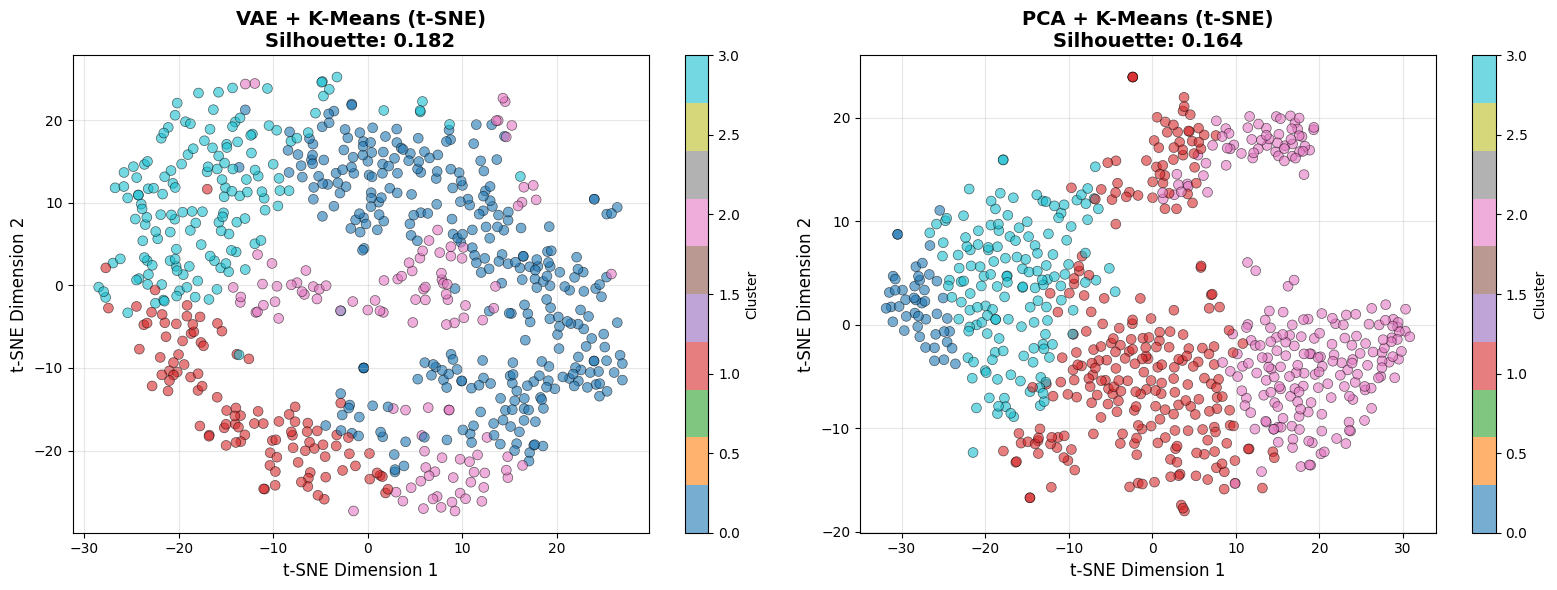

✓ t-SNE visualizations saved!


In [87]:
# ========================================
# CELL 10: t-SNE Visualization
# ========================================
print("\n" + "="*60)
print("GENERATING t-SNE VISUALIZATIONS")
print("="*60)

from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_vae = tsne.fit_transform(z_mean)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_pca = tsne.fit_transform(pca_features)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# VAE t-SNE
scatter1 = axes[0].scatter(tsne_vae[:, 0], tsne_vae[:, 1],
                           c=vae_clusters, cmap='tab10', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_title(f'VAE + K-Means (t-SNE)\nSilhouette: {vae_silhouette:.3f}',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=12)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

# PCA t-SNE
scatter2 = axes[1].scatter(tsne_pca[:, 0], tsne_pca[:, 1],
                           c=pca_clusters, cmap='tab10', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].set_title(f'PCA + K-Means (t-SNE)\nSilhouette: {pca_silhouette:.3f}',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_path + 'tsne_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ t-SNE visualizations saved!")


GENERATING UMAP VISUALIZATIONS


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


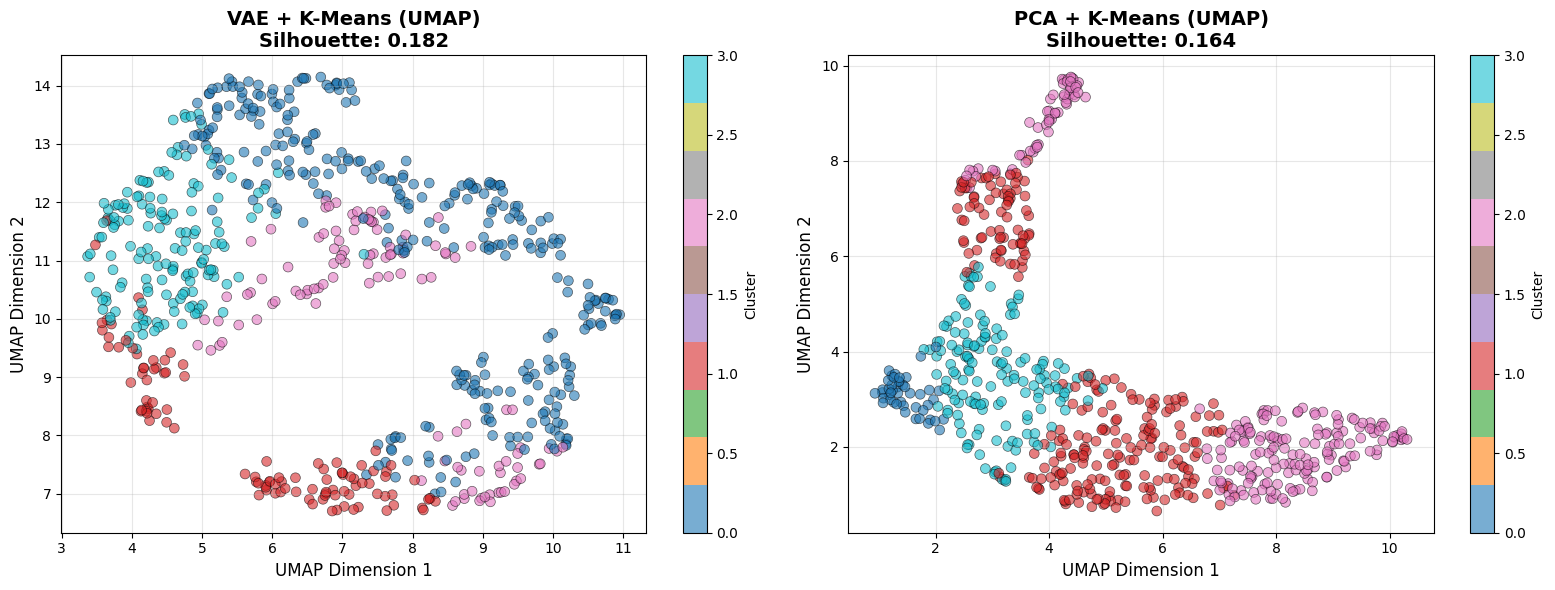

✓ UMAP visualizations saved!


In [88]:
# ========================================
# CELL 11: UMAP Visualization
# ========================================
print("\n" + "="*60)
print("GENERATING UMAP VISUALIZATIONS")
print("="*60)

import umap

# Apply UMAP
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
umap_vae = reducer.fit_transform(z_mean)

reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
umap_pca = reducer.fit_transform(pca_features)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# VAE UMAP
scatter1 = axes[0].scatter(umap_vae[:, 0], umap_vae[:, 1],
                           c=vae_clusters, cmap='tab10', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_title(f'VAE + K-Means (UMAP)\nSilhouette: {vae_silhouette:.3f}',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('UMAP Dimension 1', fontsize=12)
axes[0].set_ylabel('UMAP Dimension 2', fontsize=12)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

# PCA UMAP
scatter2 = axes[1].scatter(umap_pca[:, 0], umap_pca[:, 1],
                           c=pca_clusters, cmap='tab10', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].set_title(f'PCA + K-Means (UMAP)\nSilhouette: {pca_silhouette:.3f}',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP Dimension 1', fontsize=12)
axes[1].set_ylabel('UMAP Dimension 2', fontsize=12)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_path + 'umap_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ UMAP visualizations saved!")

In [91]:
import os
import shutil

print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Define the results folder and output zip path
results_folder_path = base_path + 'results'
output_zip_path = base_path + 'results_archive'

# Create the results directory if it doesn't exist
os.makedirs(results_folder_path, exist_ok=True)

# Models are not saved as per user request
# vae.save(results_folder_path + '/vae_model.h5')
# encoder.save(results_folder_path + '/encoder_model.h5')
# decoder.save(results_folder_path + '/decoder_model.h5')
print("✓ Models not saved as per user request")

# Save latent features to results folder
np.save(results_folder_path + '/latent_features_vae.npy', z_mean)
np.save(results_folder_path + '/latent_features_pca.npy', pca_features)
print("✓ Latent features saved to results folder")

# Save clusters to results folder
np.save(results_folder_path + '/clusters_vae.npy', vae_clusters)
np.save(results_folder_path + '/clusters_pca.npy', pca_clusters)
print("✓ Cluster assignments saved to results folder")

# Move other generated files to the results folder (if they exist in base_path)
# Note: training_history.png, tsne_comparison.png, umap_comparison.png, clustering_metrics.csv are created in base_path
files_to_move = [
    'clustering_metrics.csv',
    'training_history.png',
    'tsne_comparison.png',
    'umap_comparison.png'
]

for f in files_to_move:
    source_path = os.path.join(base_path, f)
    destination_path = os.path.join(results_folder_path, f)
    if os.path.exists(source_path):
        shutil.move(source_path, destination_path)
        print(f"✓ Moved {f} to results folder")
    else:
        print(f"⚠️ Warning: {f} not found in {base_path}")

# Create a zip archive of the results folder
shutil.make_archive(output_zip_path, 'zip', results_folder_path)
print(f"✓ All results zipped to {output_zip_path}.zip")

print("\n" + "="*60)
print("EASY TASK COMPLETE! 🎉")
print("="*60)
print("\nAll results saved in a zip archive:", output_zip_path + '.zip')
print("\nYou now have:")
print("  ✓ Clustering results (VAE + PCA)")
print("  ✓ Metrics (Silhouette, Calinski-Harabasz)")
print("  ✓ Visualizations (t-SNE, UMAP)")
print("  ✓ All files for your report, conveniently zipped!")


SAVING RESULTS
✓ Models not saved as per user request
✓ Latent features saved to results folder
✓ Cluster assignments saved to results folder
✓ Moved clustering_metrics.csv to results folder
✓ Moved training_history.png to results folder
✓ Moved tsne_comparison.png to results folder
✓ Moved umap_comparison.png to results folder
✓ All results zipped to /content/results_archive.zip

EASY TASK COMPLETE! 🎉

All results saved in a zip archive: /content/results_archive.zip

You now have:
  ✓ Clustering results (VAE + PCA)
  ✓ Metrics (Silhouette, Calinski-Harabasz)
  ✓ Visualizations (t-SNE, UMAP)
  ✓ All files for your report, conveniently zipped!
